In [69]:
using Revise
using AnalyticSensitivity, DifferentialEquations, Enzyme, DiffEqSensitivity, Enzyme, ForwardDiff, Plots
gr(format=:png)

Plots.GRBackend()

In [2]:
versioninfo()

Julia Version 1.6.3-pre.75
Commit 11e64d1c57 (2021-09-07 14:31 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i9-10900KF CPU @ 3.70GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)
Environment:
  JULIA = ~/julia
  JULIA_NUM_THREADS = 8


The following computes the relative difference between the analytic method $f(t)$ and the DES.jl method $g(t)$, defined as

$$
\frac{10^{-16} + |f(t) - g(t)|}{ 1 + |g(t)| }
$$

In [3]:
function reldiff(x, y)
    (1e-16 .+ abs.(x .- y)) ./ (1 .+ abs.(y))
end

reldiff (generic function with 1 method)

In [177]:
# system = DiffEqBase.ODEFunction(CARRGO)
# x0 = [1.25e4, 6.25e2] 
# params = [6.0e-9, 3.0e-11, 1.0e-6, 6.0e-2, 1.0e9]
# labs = ["original" "(1) kappa1" "(2) kappa2" "(3) theta" "(4) rho" "(5) gamma"]
# tspan = (0.0, 10.0)
# ϵ = 1e-16

system = DiffEqBase.ODEFunction(SIR)
N, n = 3.48e8, 100
x0 = [N - n, n, 0.0]
params = [0.105, 0.12, N]
labs = ["original" "(1) eta" "(2) delta" "(3) N"]
tspan = (0.0, 100.0)
ϵ = 1e-6

alg = AutoVern9(Rodas5(autodiff=false))
tol = 1e-12
# sensealg = ForwardDiffOverAdjoint(QuadratureAdjoint(autojacvec=EnzymeVJP()))
sensealg = nothing

# compute partial derivatives
print("Analytic 1st")
am1 = @time analytic_method(Order1(), system, x0, params, tspan, ϵ, alg=alg, abstol=tol, reltol=tol)
print("Analytic 2nd")
am2 = @time analytic_method(Order2(), system, x0, params, tspan, sqrt(ϵ), alg=alg, abstol=tol, reltol=tol)
print("DES 1st     ")
de1 = @time DES(Order1(), system, x0, params, tspan, alg=alg, abstol=tol, reltol=tol)
print("DES 2nd     ")
de2 = @time DES(Order2(), system, x0, params, tspan, sensealg, alg=alg, abstol=tol, reltol=tol)
print("FD 1st      ")
fd1 = @time FD(Order1(), system, x0, params, tspan, alg=alg, abstol=tol, reltol=tol)
print("FD 2nd      ")
fd2 = @time FD(Order2(), system, x0, params, tspan, alg=alg, abstol=tol, reltol=tol);

Analytic 1st  0.001929 seconds (4.70 k allocations: 5.849 MiB)
Analytic 2nd  0.003128 seconds (13.39 k allocations: 16.917 MiB)
DES 1st       0.000476 seconds (1.20 k allocations: 1.425 MiB)
DES 2nd       3.224345 seconds (40.07 M allocations: 7.100 GiB, 26.15% gc time)
FD 1st        0.000592 seconds (2.05 k allocations: 2.778 MiB)
FD 2nd        0.035477 seconds (197.69 k allocations: 14.477 MiB)


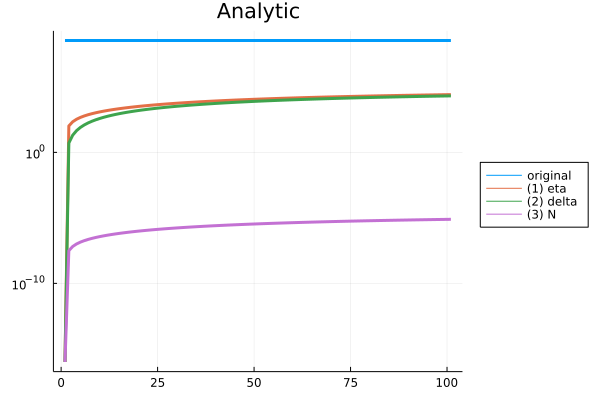

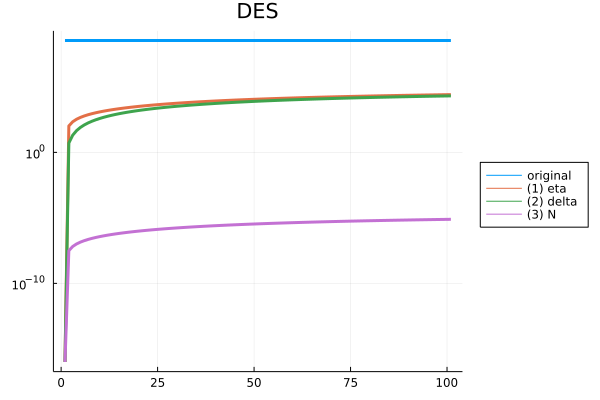

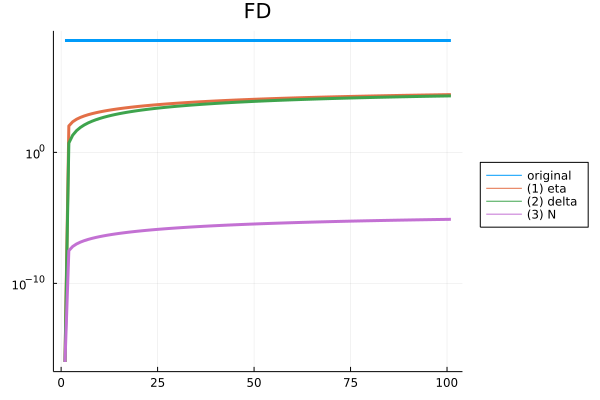

In [178]:
var = 1
display(plot(1e-16 .+ abs.(am1[var]), labels=labs, lw=3, legend=:outerright, yscale=:log10, title="Analytic"))
display(plot(1e-16 .+ abs.(de1[var]), labels=labs, lw=3, legend=:outerright, yscale=:log10, title="DES"))
display(plot(1e-16 .+ abs.(fd1[var]), labels=labs, lw=3, legend=:outerright, yscale=:log10, title="FD"))

## Comparison of 1st derivatives

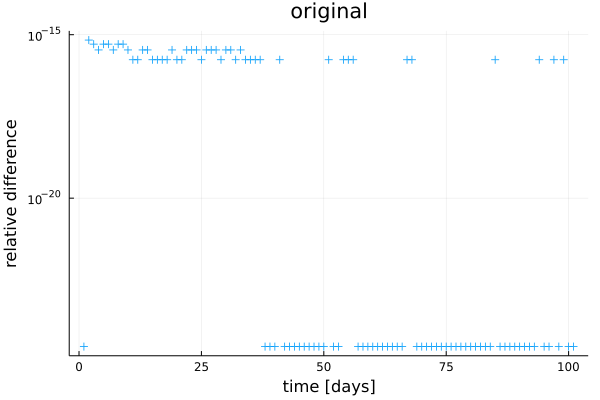

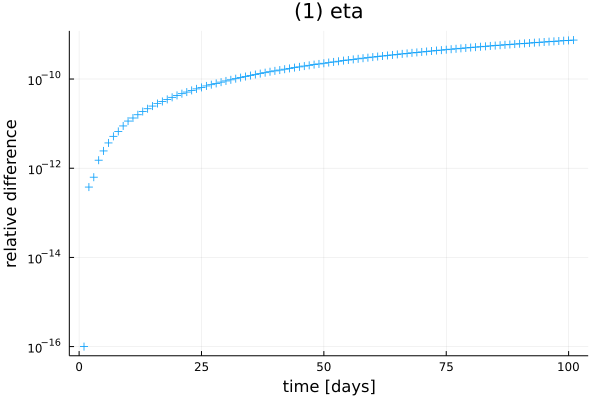

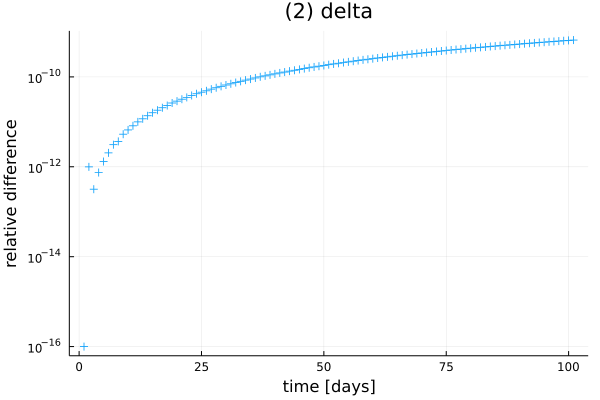

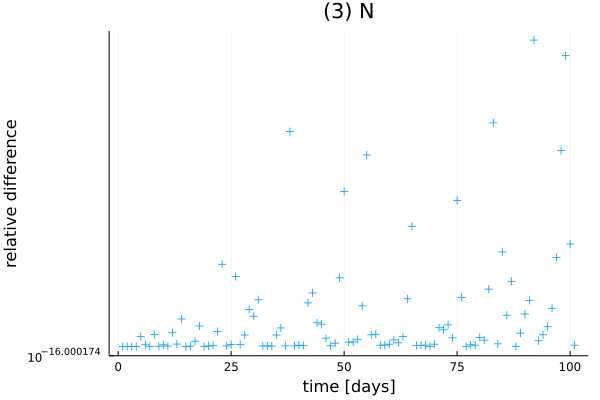

┌ Warning: No strict ticks found
└ @ PlotUtils /home/alanderos/.julia/packages/PlotUtils/ebPq2/src/ticks.jl:295
┌ Warning: No strict ticks found
└ @ PlotUtils /home/alanderos/.julia/packages/PlotUtils/ebPq2/src/ticks.jl:295


In [179]:
var = 1
for j in 1:1+length(params)
    fig = scatter(reldiff(am1[var][:,j], de1[var][:,j]),
        xlabel="time [days]",
        ylabel="relative difference",
        title=labs[j],
        marker=:+,
        legend=nothing,
        yscale=:log10,
    )
    display(fig)
end

## Comparison of 2nd derivatives

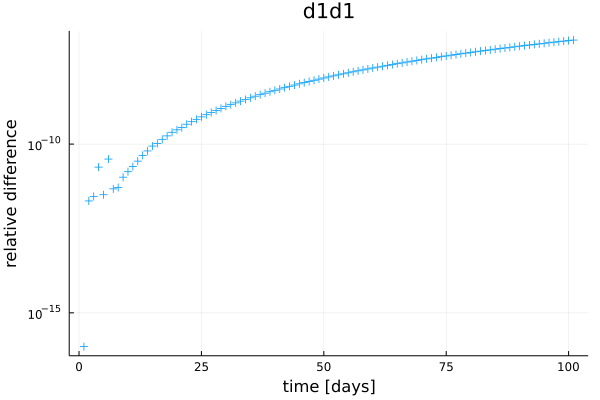

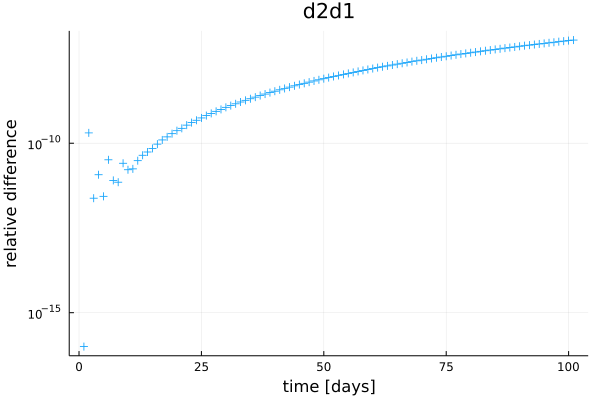

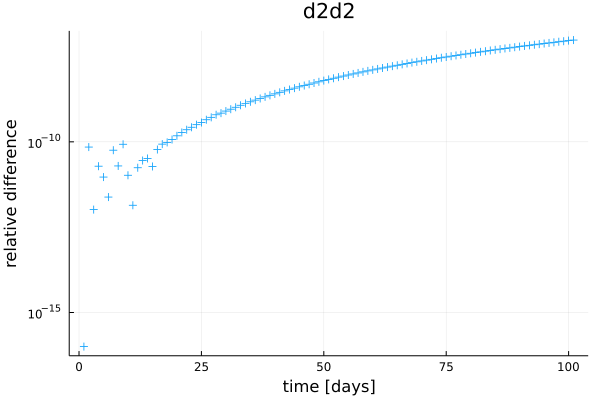

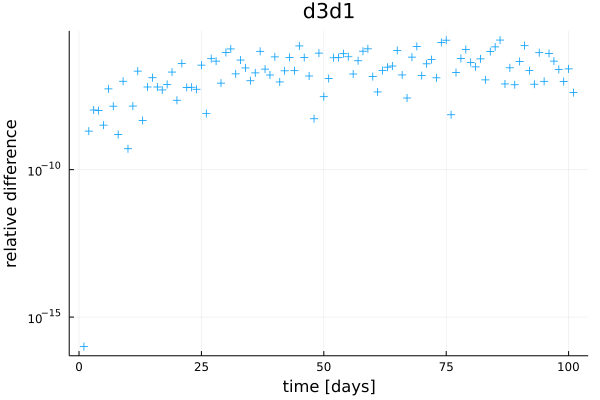

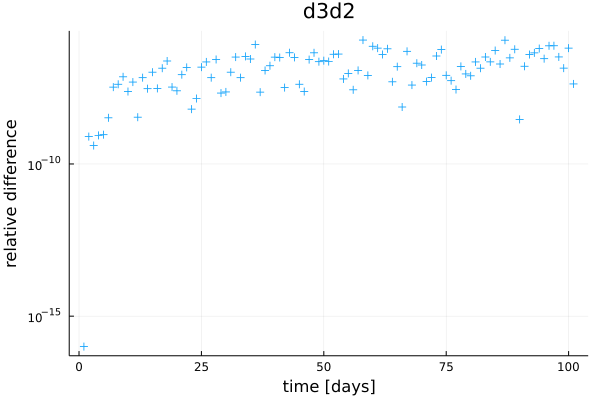

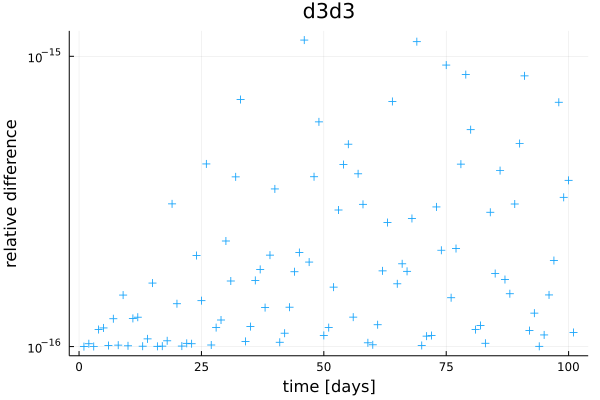

In [180]:
var = 1
for j in 1:length(params), k in 1:j
    jk = parse(Int, string(j, k))
    fig = scatter(reldiff(am2[jk][var], de2[jk][var]),
        xlabel="time [days]",
        ylabel="relative difference",
        title="d$(j)d$(k)",
        marker=:+,
        legend=nothing,
        yscale=:log10,
    )
    display(fig)
end

## Comparison of 1st order predictions

In [181]:
perturb = 0.1*params

amp1 = predict(Order1(), am1, perturb)
dep1 = predict(Order1(), de1, perturb);

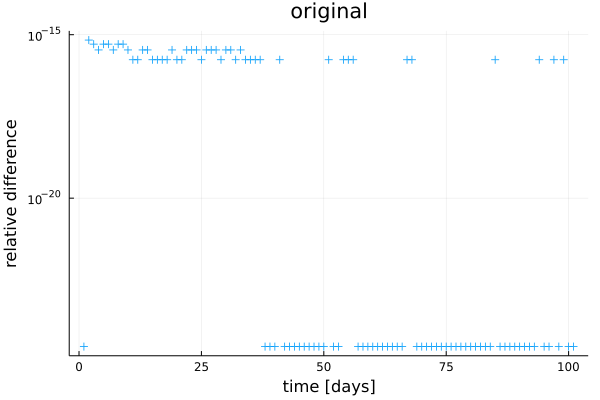

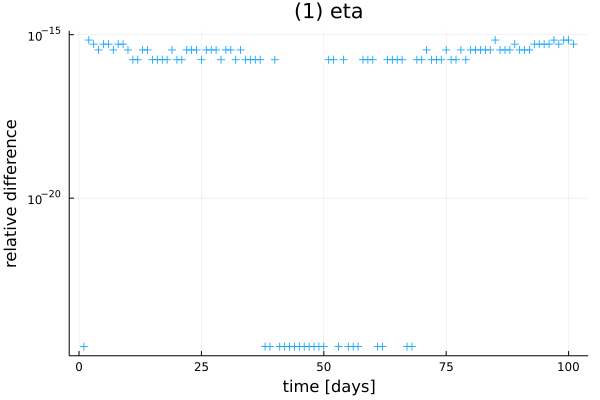

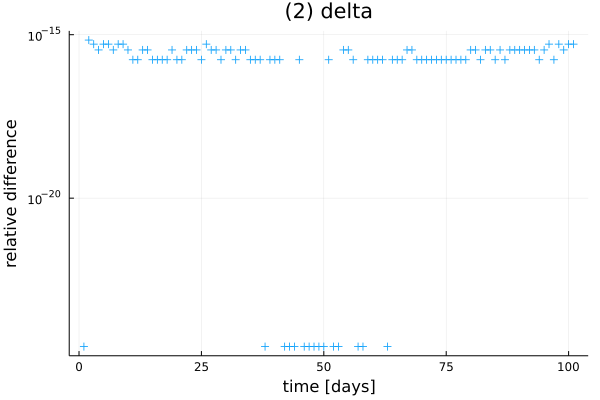

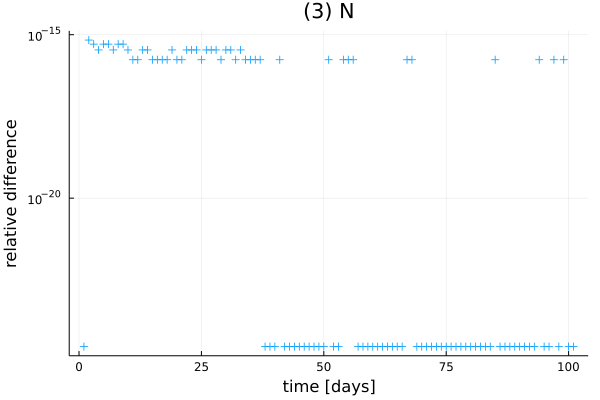

In [182]:
var = 1
for j in 1:1+length(params)
    fig = scatter(reldiff(amp1[var][:,j], dep1[var][:,j]),
        xlabel="time [days]",
        ylabel="relative difference",
        title=labs[j],
        marker=:+,
        legend=nothing,
        yscale=:log10,
    )
    display(fig)
end

## Comparison of 2nd order predictions

In [183]:
perturb = 0.1*params

amp2 = predict(Order2(), am1, am2, perturb)
dep2 = predict(Order2(), de1, de2, perturb);

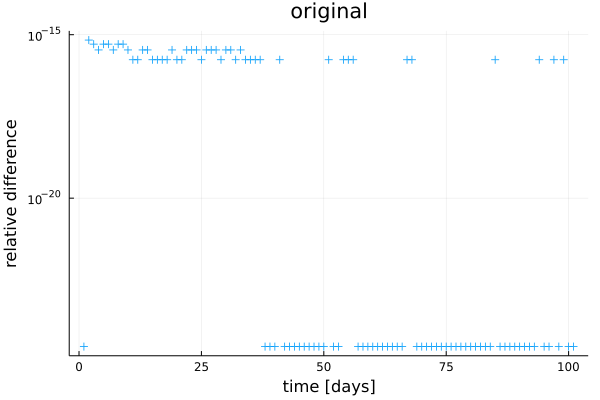

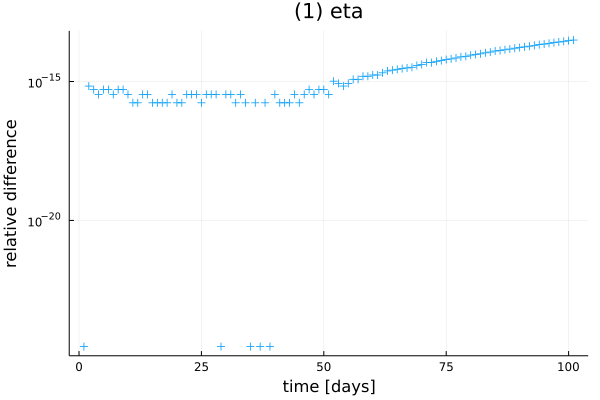

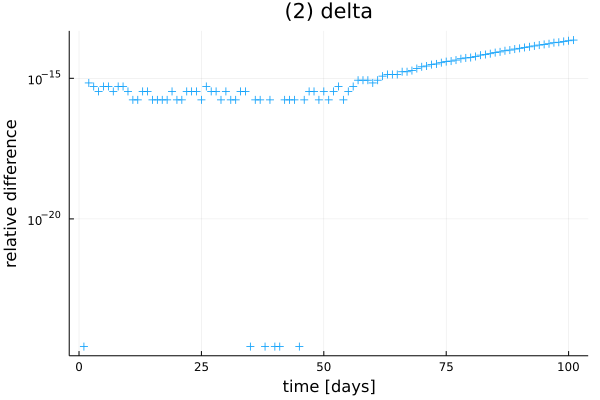

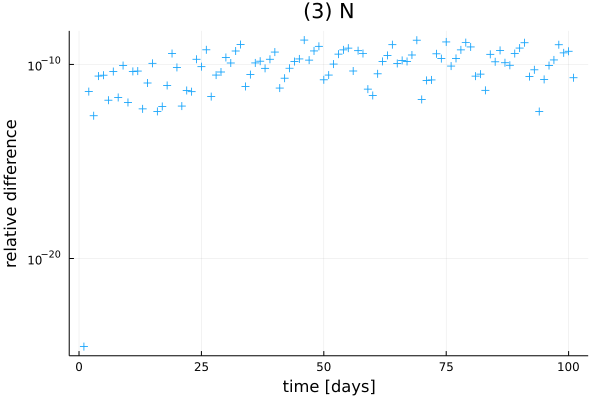

In [184]:
var = 1

for j in 1:1+length(params)
    fig = scatter(reldiff(amp2[var][:,j], dep2[var][:,j]),
        xlabel="time [days]",
        ylabel="relative difference",
        title=labs[j],
        marker=:+,
        legend=nothing,
        yscale=:log10,
    )
    display(fig)
end